# Scratch work

Scratch note for visualizing Gaussian field

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:

def plot_2D(data_info,title,input_label,output_label,axis_bounds=None,xscale=None,yscale=None):

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)

    for info_cache in data_info:
        plt.plot(info_cache[0][0],info_cache[0][1],info_cache[1],label=info_cache[2],linewidth=1.5,markersize=10)

    plt.title(title,fontsize=24)
    plt.xlabel(input_label,fontsize=20)
    plt.ylabel(output_label,fontsize=20)
    if not axis_bounds == None:
        plt.axis(axis_bounds)
    if not xscale == None:
        plt.xscale(xscale)
    if not yscale == None:
        plt.yscale(yscale)
    plt.legend(loc='best',fontsize=14)
    plt.show()
    


In [3]:

def FindNearest(array, value):
    ind = (np.abs(array - value)).argmin()
    return ind

def UseMax(arrSmall, arrBig):
    assert(len(arrSmall) <= len(arrBig))
    for i in range(len(arrSmall)):
        if (arrSmall[i] > arrBig[i]):
            arrBig[i] = arrSmall[i]
    return arrBig

def GaussPDFwrap(start, end, mu, sigma, Xspace):
    delX = Xspace[1]-Xspace[0]
    n = (end-start)/delX
    Y = np.zeros(len(Xspace))
    left = mu-3*sigma
    right = mu+3*sigma
    head = start
    tail = end
    
    Y = stats.norm.pdf(Xspace, mu, sigma)
    
    if(left < 0):
        #left wrap-around
        head = end+left
        ind_head = FindNearest(Xspace, head)
        siz = len(Y[ind_head:])
        x1 = np.arange(left, start+delX, delX)[:siz]
        #use the larger pdf value for left tail (on the right side of graph)
        Y[ind_head:] = UseMax(Y[ind_head:], stats.norm.pdf(x1, mu, sigma))
        
    if(right > end):
        #right wrap-around
        tail = right-end
        ind_tail = FindNearest(Xspace, tail)
        siz = len(Y[:ind_tail])
        x1 = np.arange(end, right+delX, delX)[:siz]
        #use the larger pdf value for right tail (on the left side of graph)
        Y[:ind_tail] = UseMax(Y[:ind_tail], stats.norm.pdf(x1, mu, sigma))
        
    return Y

def GaussPDFin2D(mu, Sigma, pos):
    #cited from https://stackoverflow.com/a/55737551
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# Tuning Curve Functions

In [4]:
def OrientTuningCurve(theta, Xspace):
    #generates tuning curve w.r.t. to the given theta (preferred orientation)
    #num = number of nodes in the interval [0, pi]
    assert(0 <= theta and theta <= np.pi)
    [mu, var] = theta, 0.3
    return GaussPDFwrap(0, np.pi, mu, var, Xspace)

def PosTuningCurve(x, y, X, Y):
    #generates tuning curve w.r.t. to the given center (x, y)
    #num = number of nodes in the interval [-10,10] x [-10,10]
    assert(X[0] <= x and x <= X[-1])
    assert(Y[0] <= y and y <= Y[-1])
    mu = np.array([x, y])
    Sigma = np.array([[2 , 0.], [0.,  2]]) #var = 2
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Res = GaussPDFin2D(mu, Sigma, pos)
    return Res

def MixedResponse(neuron, stimulus, xylim, xynum, thetanum):
    #returns the response of a neuron with preferred position and orientation
    #w.r.t. the stimulus position and orientation
    [x, y, theta] = neuron
    [st_x, st_y, st_the] = stimulus
    [xlim, ylim] = xylim
    assert(0 <= theta and theta <= np.pi)
    assert(0 <= st_the and st_the <= np.pi)
    assert(-1*xlim <= x and x <= xlim)
    assert(-1*ylim <= y and y <= ylim)
    assert(-1*xlim-2 <= sti_x and sti_x <= xlim+2)
    assert(-1*ylim-2 <= sti_y and sti_y <= ylim+2)
    A = np.linspace(0, np.pi, thetanum, endpoint = True)
    X = np.linspace(-1*xlim-2, xlim+2, xynum, endpoint = True)
    Y = np.linspace(-1*ylim-2, ylim+2, xynum, endpoint = True)
    st_x_ind = FindNearest(X, st_x)
    st_y_ind = FindNearest(Y, st_y)
    st_the_ind = FindNearest(A, st_the)
    
    X, Y = np.meshgrid(X, Y)
    Ro = OrientTuningCurve(theta, A)[st_the_ind]
    Rs = PosTuningCurve(x, y, X, Y)[st_x_ind, st_y_ind]
    return Ro * Rs
    

In [3]:
(0.4*16+0.45*4+0.5*3+0.6*1+0.95*6)/30

0.5333333333333333

# Tests

(4, 4)


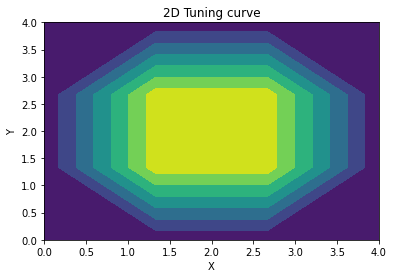

In [5]:
def test1D():
    mu = 3
    variance = 0.3
    sigma = math.sqrt(variance)

    [start, end] = 0, np.pi #preferred orientation
    Xnum = 50
    Xspace = np.linspace(start, end, Xnum, endpoint = True)
    Y = GaussPDFwrap(start, end, mu, sigma, Xspace)
    plt.plot(Xspace,Y)
#test1D()

def test2D():
    N = 4
    X = np.linspace(0, 4, N)
    Y = np.linspace(0, 4, N)
    X, Y = np.meshgrid(X, Y)
    mu = np.array([2., 2.])
    Sigma = np.array([[ 0.5 , 0.], [0.,  0.5]])
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = GaussPDFin2D(mu, Sigma, pos)
    newZ = np.zeros((4,4))
    newZ[2,2] = Z[2,2]
    plt.contourf(X, Y, Z, cmap='viridis')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title('2D Tuning curve')
    print(Z.shape)
test2D()

# Multi-neuron simulation

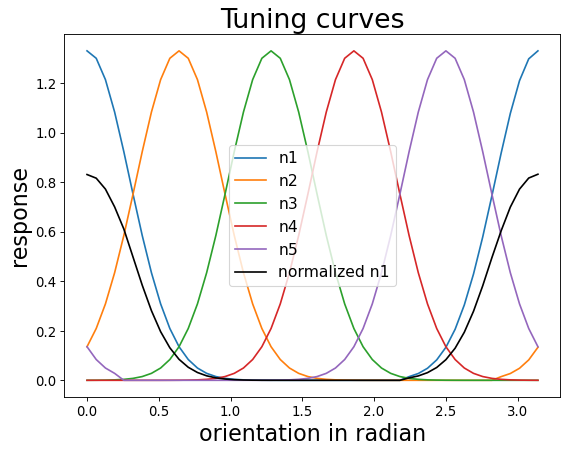

In [6]:
def neuron5curve():
    neuron = 5
    theta = np.arange(0,np.pi,np.pi/5) #evenly spaced preferred orientation
    Xnum = 50
    Xspace = np.linspace(0, np.pi, Xnum, endpoint = True)
    Y = np.zeros((len(Xspace), neuron))
    for i in range(neuron):
        the = FindNearest(Xspace, theta[i])
        Y[:,i] = OrientTuningCurve(Xspace[the], Xspace)

    return Xspace, Y #the tuning curves for 5 neurons

Xspace, Y = neuron5curve()
N1 = Y[:,0] #fix neuron no.1
Nmlzd = Y[:,0]/np.sum(Y, axis = 1) #basic normalization

data_info = [[[Xspace,Y[:,0]],'-','n1'], 
                 [[Xspace,Y[:,1]],'-','n2'], [[Xspace,Y[:,2]],'-','n3'], 
                 [[Xspace,Y[:,3]],'-','n4'], [[Xspace,Y[:,4]],'-','n5'],
                [[Xspace,Nmlzd],'k-','normalized n1']]
plot_2D(data_info,
            title='Tuning curves',
            input_label='orientation in radian',
            output_label='response')

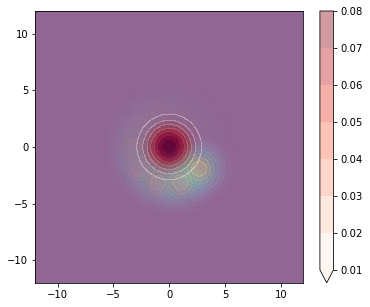

In [13]:
'''Basic plotting function to visualize neuron pool 
    as a circle and the target neuron in the center'''
'''Circular setup, not for actual simluation'''
def MultiNeuronPoscurve():
    neuronnum = 10
    lim = 10
    xynum = 50
    r = 2.5+(neuronnum-2)/neuronnum
    X = np.linspace(-1*lim-2, lim+2, xynum, endpoint = True)
    Y = np.linspace(-1*lim-2, lim+2, xynum, endpoint = True)
    neuron = np.zeros((2,neuronnum))
    Z = np.zeros((xynum, xynum, neuronnum))
    for i in range(neuronnum):
        neuron[0,i] = r*np.cos(2*i*np.pi/neuronnum)
        neuron[1,i] =  r*np.sin(2*i*np.pi/neuronnum)
    fig = plt.figure(figsize=(6,5))
    ax = plt.subplot(111)
    color = ['Reds','Greens','Blues','viridis','Purples']
    for i in range(neuronnum):
        
        Z[:,:,i] = PosTuningCurve(neuron[0,i],neuron[1,i], X, Y)
        g =  ax.contourf(X,Y,Z[:,:,i],alpha=.3,cmap='viridis',extend='min')
    Tar= PosTuningCurve(0,0, X, Y)
    g = ax.contourf(X,Y,Tar,alpha=.4,cmap='Reds',extend='min')
    plt.colorbar(g)
    plt.show()
MultiNeuronPoscurve()

Created by Ricky Huang